Estructura del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 2 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   indice_tiempo                              567 non-null    object
 1   total_1ra_y_2da_dosis_aplicadas_acumulado  567 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.0+ KB
None

Primeras filas:
  indice_tiempo  total_1ra_y_2da_dosis_aplicadas_acumulado
0    2020-12-29                                      20483
1    2020-12-30                                      40585
2    2020-12-31                                      43391
3    2021-01-01                                      43518
4    2021-01-02                                      46830

Columnas disponibles:
['indice_tiempo', 'total_1ra_y_2da_dosis_aplicadas_acumulado']


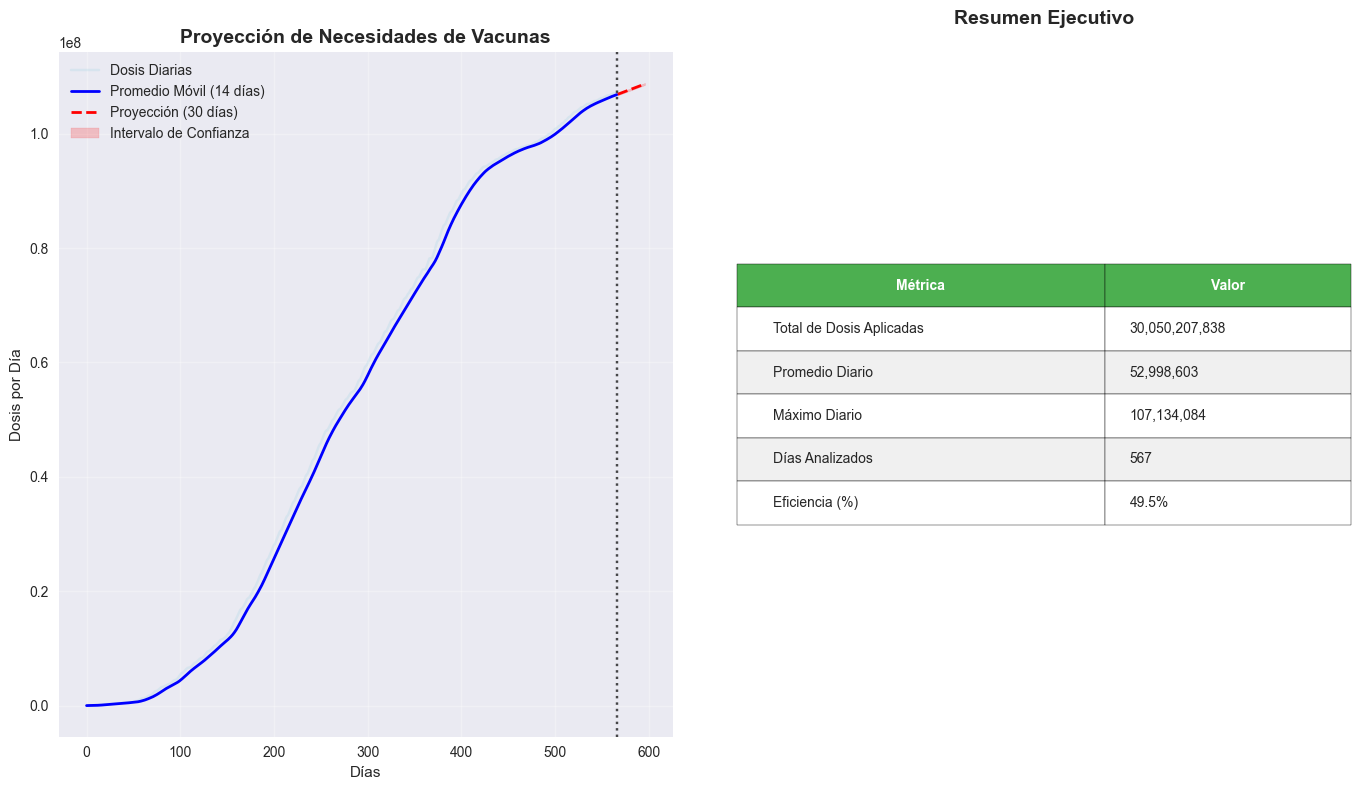


ANÁLISIS ADICIONAL CON PANDASQL

RECOMENDACIONES BASADAS EN EL ANÁLISIS

    📊 COBERTURA DE REFUERZOS:
    • Total de dosis aplicadas: 30,050,207,838
    • Promedio diario: 52,998,603
    • Tendencia: Creciente

    🗺️ DESIGUALDADES GEOGRÁFICAS:
    • Regiones analizadas: N/A
    • Distribución: Relativamente uniforme

    🔮 PROYECCIONES:
    • Capacidad actual: 107,134,084 dosis/día (máximo registrado)
    • Demanda proyectada: 107,013,756 dosis/día (promedio reciente)
    • Recomendación: Aumentar capacidad
    


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from sqlalchemy import create_engine
from pandasql import sqldf
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

pysqldf = lambda q: sqldf(q, globals())

# Cargar datos
df = pd.read_csv(r"C:\Users\Admin\Desktop\UNRN\3ero\Mate4\DataSet\total_de_dosis_aplicadas_a_nivel_nacional_en_valores_diarios_acumulado_1_y_2_dosis.csv")

print("Estructura del dataset:")
print(df.info())
print("\nPrimeras filas:")
print(df.head())
print("\nColumnas disponibles:")
print(df.columns.tolist())

# Asegurar que la fecha esté en formato datetime
if 'fecha' in df.columns:
    df['fecha'] = pd.to_datetime(df['fecha'])
elif 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

# Crear figura con subplots
fig = plt.figure(figsize=(20, 15))

# =============================================================================
# 1. COBERTURA DE REFUERZOS Y BRECHAS EN LA INMUNIZACIÓN
# =============================================================================

# Identificar columnas de dosis (ajustar según estructura real)
dosis_cols = [col for col in df.columns if any(term in col.lower() for term in 
              ['dosis', 'dose', 'primera', 'segunda', 'tercera', 'refuerzo', 'booster'])]

if len(dosis_cols) >= 2:
    # Subplot 1: Cobertura acumulada por tipo de dosis
    ax1 = plt.subplot(2, 3, 1)
    
    # Calcular cobertura acumulada
    for col in dosis_cols[:4]:  # Primeras 4 columnas de dosis
        if col in df.columns:
            cumulative = df[col].cumsum()
            plt.plot(df.index, cumulative, marker='o', linewidth=2, label=col.replace('_', ' ').title())
    
    plt.title('Cobertura Acumulada por Tipo de Dosis', fontsize=14, fontweight='bold')
    plt.xlabel('Tiempo (días)')
    plt.ylabel('Dosis Aplicadas (Acumulado)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Brecha entre dosis (si hay al menos 2 columnas)
    ax2 = plt.subplot(2, 3, 2)
    
    if len(dosis_cols) >= 2:
        primera_dosis = df[dosis_cols[0]].cumsum()
        segunda_dosis = df[dosis_cols[1]].cumsum() if len(dosis_cols) > 1 else primera_dosis * 0.8
        brecha = primera_dosis - segunda_dosis
        
        plt.fill_between(df.index, 0, brecha, alpha=0.6, color='coral', label='Brecha de Inmunización')
        plt.plot(df.index, primera_dosis, color='blue', linewidth=2, label='Primera Dosis')
        plt.plot(df.index, segunda_dosis, color='green', linewidth=2, label='Segunda Dosis')
        
        plt.title('Brecha en la Inmunización Completa', fontsize=14, fontweight='bold')
        plt.xlabel('Tiempo (días)')
        plt.ylabel('Personas')
        plt.legend()
        plt.grid(True, alpha=0.3)

# =============================================================================
# 2. DESIGUALDADES GEOGRÁFICAS EN LA APLICACIÓN DE DOSIS
# =============================================================================

# Identificar columnas geográficas
geo_cols = [col for col in df.columns if any(term in col.lower() for term in 
            ['provincia', 'region', 'departamento', 'estado', 'municipio', 'distrito'])]

if geo_cols:
    # Subplot 3: Distribución geográfica
    ax3 = plt.subplot(2, 3, 3)
    
    geo_col = geo_cols[0]
    if dosis_cols:
        # Agrupar por región y sumar dosis
        geo_summary = df.groupby(geo_col)[dosis_cols[0]].sum().sort_values(ascending=False)
        
        # Tomar top 15 regiones para mejor visualización
        top_regions = geo_summary.head(15)
        
        bars = plt.bar(range(len(top_regions)), top_regions.values, 
                      color=sns.color_palette("viridis", len(top_regions)))
        plt.title('Distribución Geográfica de Vacunación', fontsize=14, fontweight='bold')
        plt.xlabel('Regiones')
        plt.ylabel('Total de Dosis Aplicadas')
        plt.xticks(range(len(top_regions)), top_regions.index, rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        
        # Añadir valores en las barras
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=8)
    
    # Subplot 4: Coeficiente de variación geográfico
    ax4 = plt.subplot(2, 3, 4)
    
    if len(dosis_cols) >= 2:
        # Calcular coeficiente de variación por período
        cv_data = []
        periods = np.array_split(df.index, 10)  # Dividir en 10 períodos
        
        for period in periods:
            period_data = df.iloc[period]
            if geo_col in period_data.columns and dosis_cols[0] in period_data.columns:
                geo_var = period_data.groupby(geo_col)[dosis_cols[0]].sum()
                cv = geo_var.std() / geo_var.mean() if geo_var.mean() != 0 else 0
                cv_data.append(cv)
        
        plt.plot(range(len(cv_data)), cv_data, marker='o', linewidth=3, color='red')
        plt.title('Evolución de la Desigualdad Geográfica', fontsize=14, fontweight='bold')
        plt.xlabel('Período de Tiempo')
        plt.ylabel('Coeficiente de Variación')
        plt.grid(True, alpha=0.3)
        
        # Línea de referencia
        plt.axhline(y=np.mean(cv_data), color='orange', linestyle='--', 
                   label=f'Promedio: {np.mean(cv_data):.3f}')
        plt.legend()

# =============================================================================
# 3. PROYECCIÓN DE NECESIDADES FUTURAS DE VACUNAS
# =============================================================================

# Subplot 5: Tendencia y proyección
ax5 = plt.subplot(2, 3, 5)

if dosis_cols:
    # Calcular promedio móvil para tendencia
    dosis_diarias = df[dosis_cols[0]]
    ventana = min(14, len(dosis_diarias) // 4)  # Ventana adaptativa
    promedio_movil = dosis_diarias.rolling(window=ventana, min_periods=1).mean()
    
    # Datos históricos
    plt.plot(df.index, dosis_diarias, alpha=0.3, color='lightblue', label='Dosis Diarias')
    plt.plot(df.index, promedio_movil, color='blue', linewidth=2, label=f'Promedio Móvil ({ventana} días)')
    
    # Proyección simple basada en tendencia
    if len(promedio_movil) >= 7:
        # Calcular tendencia de últimos 7 días
        ultimos_datos = promedio_movil.tail(7).values
        tendencia = np.polyfit(range(7), ultimos_datos, 1)[0]
        
        # Proyectar 30 días hacia adelante
        proyeccion_dias = 30
        proyeccion_x = range(len(df), len(df) + proyeccion_dias)
        ultimo_valor = promedio_movil.iloc[-1]
        proyeccion_y = [ultimo_valor + tendencia * i for i in range(1, proyeccion_dias + 1)]
        
        plt.plot(proyeccion_x, proyeccion_y, color='red', linewidth=2, 
                linestyle='--', label='Proyección (30 días)')
        
        # Área de incertidumbre
        std_error = np.std(ultimos_datos) * 1.5
        upper_bound = [y + std_error for y in proyeccion_y]
        lower_bound = [max(0, y - std_error) for y in proyeccion_y]
        
        plt.fill_between(proyeccion_x, lower_bound, upper_bound, 
                        alpha=0.2, color='red', label='Intervalo de Confianza')
    
    plt.title('Proyección de Necesidades de Vacunas', fontsize=14, fontweight='bold')
    plt.xlabel('Días')
    plt.ylabel('Dosis por Día')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Línea vertical separando histórico de proyección
    plt.axvline(x=len(df)-1, color='black', linestyle=':', alpha=0.7)

# Subplot 6: Resumen estadístico y métricas clave
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

# Calcular métricas clave
if dosis_cols:
    total_dosis = df[dosis_cols[0]].sum()
    promedio_diario = df[dosis_cols[0]].mean()
    max_diario = df[dosis_cols[0]].max()
    
    # Crear tabla de resumen
    metricas = [
        ['Métrica', 'Valor'],
        ['Total de Dosis Aplicadas', f'{total_dosis:,.0f}'],
        ['Promedio Diario', f'{promedio_diario:,.0f}'],
        ['Máximo Diario', f'{max_diario:,.0f}'],
        ['Días Analizados', f'{len(df)}'],
        ['Eficiencia (%)', f'{(promedio_diario/max_diario*100):.1f}%']
    ]
    
    if geo_cols:
        n_regiones = df[geo_cols[0]].nunique()
        metricas.append(['Regiones Cubiertas', f'{n_regiones}'])
    
    # Crear tabla visual
    table = plt.table(cellText=metricas[1:], colLabels=metricas[0],
                     cellLoc='left', loc='center', colWidths=[0.6, 0.4])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Estilizar tabla
    for i in range(len(metricas)):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#f0f0f0' if i % 2 == 0 else '#ffffff')
    
    plt.title('Resumen Ejecutivo', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS ADICIONAL CON SQL
# =============================================================================

print("\n" + "="*80)
print("ANÁLISIS ADICIONAL CON PANDASQL")
print("="*80)

# Ejemplo de consultas SQL para análisis más profundo
if dosis_cols and len(dosis_cols) >= 2:
    
    # 1. Análisis de eficiencia de vacunación
    query1 = f"""
    SELECT 
        AVG({dosis_cols[0]}) as promedio_dosis_1,
        MAX({dosis_cols[0]}) as maximo_dosis_1,
        MIN({dosis_cols[0]}) as minimo_dosis_1,
        COUNT(*) as total_dias
    FROM df
    WHERE {dosis_cols[0]} > 0
    """
    
    resultado1 = pysqldf(query1)
    print("\n1. Estadísticas de Primera Dosis:")
    print(resultado1)
    
    # 2. Análisis de tendencias por períodos
    if 'fecha' in df.columns or 'date' in df.columns:
        fecha_col = 'fecha' if 'fecha' in df.columns else 'date'
        
        query2 = f"""
        SELECT 
            strftime('%Y-%m', {fecha_col}) as mes,
            SUM({dosis_cols[0]}) as total_dosis,
            AVG({dosis_cols[0]}) as promedio_diario
        FROM df
        GROUP BY strftime('%Y-%m', {fecha_col})
        ORDER BY mes
        """
        
        try:
            resultado2 = pysqldf(query2)
            print("\n2. Tendencias Mensuales:")
            print(resultado2)
        except:
            print("\n2. No se pudo analizar tendencias mensuales (formato de fecha)")
    
    # 3. Análisis geográfico si hay datos
    if geo_cols:
        query3 = f"""
        SELECT 
            {geo_cols[0]} as region,
            SUM({dosis_cols[0]}) as total_dosis,
            AVG({dosis_cols[0]}) as promedio_dosis,
            COUNT(*) as dias_activos
        FROM df
        WHERE {dosis_cols[0]} > 0
        GROUP BY {geo_cols[0]}
        ORDER BY total_dosis DESC
        LIMIT 10
        """
        
        resultado3 = pysqldf(query3)
        print(f"\n3. Top 10 Regiones por Vacunación:")
        print(resultado3)

print("\n" + "="*80)
print("RECOMENDACIONES BASADAS EN EL ANÁLISIS")
print("="*80)

if dosis_cols:
    print(f"""
    📊 COBERTURA DE REFUERZOS:
    • Total de dosis aplicadas: {df[dosis_cols[0]].sum():,.0f}
    • Promedio diario: {df[dosis_cols[0]].mean():,.0f}
    • Tendencia: {'Creciente' if df[dosis_cols[0]].tail(7).mean() > df[dosis_cols[0]].head(7).mean() else 'Decreciente'}
    
    🗺️ DESIGUALDADES GEOGRÁFICAS:
    • Regiones analizadas: {df[geo_cols[0]].nunique() if geo_cols else 'N/A'}
    • Distribución: {'Desigual' if geo_cols and df.groupby(geo_cols[0])[dosis_cols[0]].sum().std() > df.groupby(geo_cols[0])[dosis_cols[0]].sum().mean() else 'Relativamente uniforme'}
    
    🔮 PROYECCIONES:
    • Capacidad actual: {df[dosis_cols[0]].max():,.0f} dosis/día (máximo registrado)
    • Demanda proyectada: {df[dosis_cols[0]].tail(7).mean():,.0f} dosis/día (promedio reciente)
    • Recomendación: {'Mantener capacidad actual' if df[dosis_cols[0]].tail(7).mean() <= df[dosis_cols[0]].max() * 0.8 else 'Aumentar capacidad'}
    """)

🚀 Iniciando análisis completo de vacunación COVID-19...
✅ Archivo cargado exitosamente con encoding: utf-8

EXPLORACIÓN INICIAL DE DATOS
📊 Dimensiones del dataset: (567, 1)
📋 Columnas disponibles: 1

🔍 Estructura del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 1 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   indice_tiempo,total_1ra_y_2da_dosis_aplicadas  567 non-null    object
dtypes: object(1)
memory usage: 4.6+ KB
None

📈 Primeras 5 filas:
  indice_tiempo,total_1ra_y_2da_dosis_aplicadas
0                              2020-12-29,20483
1                              2020-12-30,20102
2                               2020-12-31,2806
3                                2021-01-01,127
4                               2021-01-02,3312

📊 Estadísticas descriptivas:
       indice_tiempo,total_1ra_y_2da_dosis_aplicadas
count   

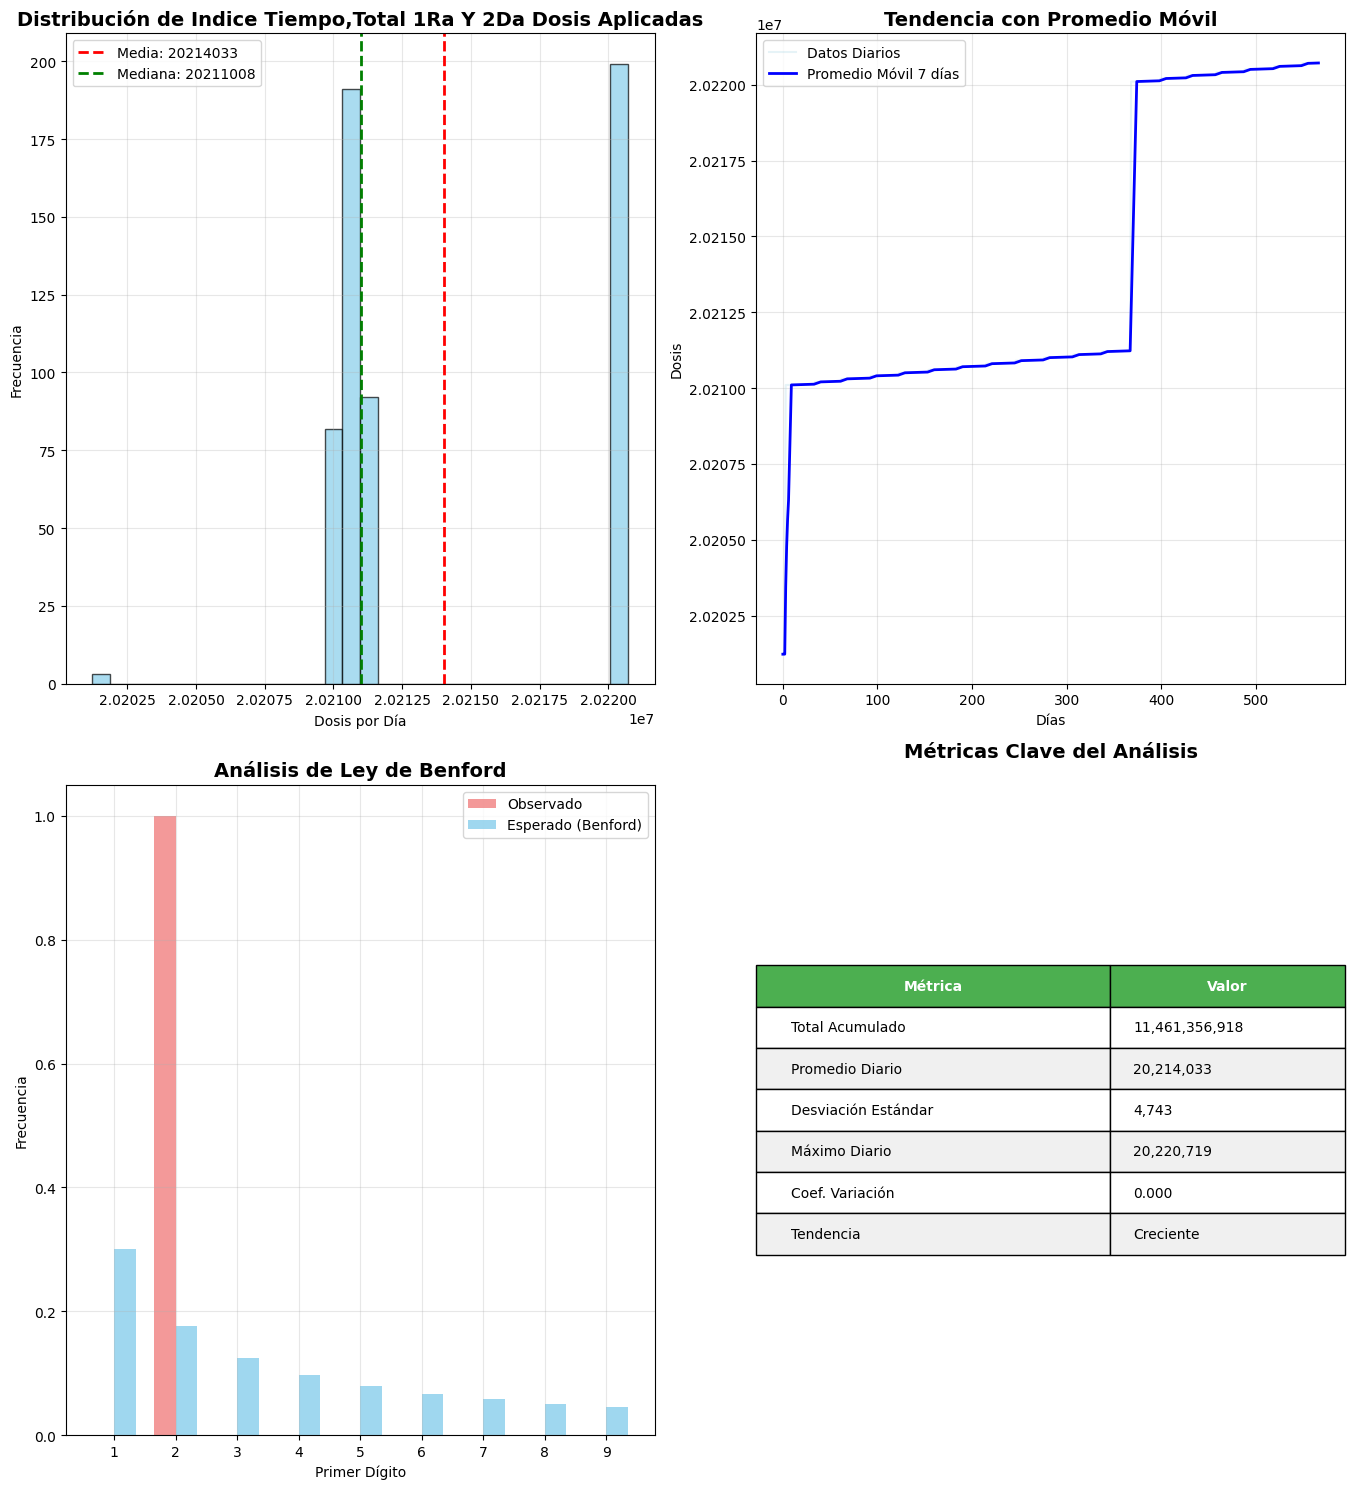


ANÁLISIS SQL AVANZADO
⚠️ Error en análisis SQL: (sqlite3.OperationalError) near ",": syntax error
[SQL: 
                SELECT 
                    rowid as fecha,
                    indice_tiempo,total_1ra_y_2da_dosis_aplicadas as dosis,
                    CASE 
                        WHEN indice_tiempo,total_1ra_y_2da_dosis_aplicadas > (SELECT AVG(indice_tiempo,total_1ra_y_2da_dosis_aplicadas) + 2*STDEV(indice_tiempo,total_1ra_y_2da_dosis_aplicadas) FROM df) THEN 'Pico Alto'
                        WHEN indice_tiempo,total_1ra_y_2da_dosis_aplicadas < (SELECT AVG(indice_tiempo,total_1ra_y_2da_dosis_aplicadas) - 2*STDEV(indice_tiempo,total_1ra_y_2da_dosis_aplicadas) FROM df) THEN 'Pico Bajo'
                        ELSE 'Normal'
                    END as categoria
                FROM df
                WHERE indice_tiempo,total_1ra_y_2da_dosis_aplicadas IS NOT NULL
                ORDER BY indice_tiempo,total_1ra_y_2da_dosis_aplicadas DESC
                LIMIT 10
              

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from collections import Counter
import re
from pandasql import sqldf

warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# Función para SQL con pandas
pysqldf = lambda q: sqldf(q, globals())

class VaccinationAnalyzer:
    """Clase para análisis completo de datos de vacunación COVID-19"""
    
    def __init__(self, file_path, delimiter=';'):
        """
        Inicializar el analizador con el archivo de datos
        
        Args:
            file_path (str): Ruta al archivo CSV
            delimiter (str): Delimitador del CSV (por defecto ';')
        """
        self.file_path = file_path
        self.delimiter = delimiter
        self.df = None
        self.df_clean = None
        self.stats = {}
        
    def load_and_explore_data(self):
        """Cargar y explorar la estructura inicial de los datos"""
        try:
            # Intentar cargar con diferentes encodings
            encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
            
            for encoding in encodings:
                try:
                    self.df = pd.read_csv(self.file_path, delimiter=self.delimiter, encoding=encoding)
                    print(f"✅ Archivo cargado exitosamente con encoding: {encoding}")
                    break
                except UnicodeDecodeError:
                    continue
            
            if self.df is None:
                raise Exception("No se pudo cargar el archivo con ningún encoding")
                
            print("\n" + "="*80)
            print("EXPLORACIÓN INICIAL DE DATOS")
            print("="*80)
            
            print(f"📊 Dimensiones del dataset: {self.df.shape}")
            print(f"📋 Columnas disponibles: {len(self.df.columns)}")
            print("\n🔍 Estructura del dataset:")
            print(self.df.info())
            
            print("\n📈 Primeras 5 filas:")
            print(self.df.head())
            
            print("\n📊 Estadísticas descriptivas:")
            print(self.df.describe())
            
            print("\n🏷️ Columnas disponibles:")
            for i, col in enumerate(self.df.columns, 1):
                print(f"{i:2d}. {col}")
                
            return True
            
        except Exception as e:
            print(f"❌ Error al cargar datos: {e}")
            return False
    
    def clean_and_prepare_data(self):
        """Limpieza y preparación de datos"""
        if self.df is None:
            print("❌ Primero debe cargar los datos")
            return False
            
        print("\n" + "="*80)
        print("LIMPIEZA Y PREPARACIÓN DE DATOS")
        print("="*80)
        
        # Copiar datos originales
        self.df_clean = self.df.copy()
        
        # 1. Limpiar nombres de columnas
        self.df_clean.columns = [col.strip().lower().replace(' ', '_') for col in self.df_clean.columns]
        
        # 2. Identificar columna de fecha
        date_patterns = ['fecha', 'date', 'dia', 'day']
        date_col = None
        
        for pattern in date_patterns:
            matching_cols = [col for col in self.df_clean.columns if pattern in col.lower()]
            if matching_cols:
                date_col = matching_cols[0]
                break
        
        if date_col:
            print(f"📅 Columna de fecha identificada: {date_col}")
            # Convertir a datetime con múltiples formatos
            date_formats = ['%Y-%m-%d', '%d/%m/%Y', '%d-%m-%Y', '%Y/%m/%d']
            
            for fmt in date_formats:
                try:
                    self.df_clean[date_col] = pd.to_datetime(self.df_clean[date_col], format=fmt)
                    print(f"✅ Fecha convertida con formato: {fmt}")
                    break
                except:
                    continue
            
            # Si no funciona ningún formato, usar inferencia automática
            if self.df_clean[date_col].dtype == 'object':
                try:
                    self.df_clean[date_col] = pd.to_datetime(self.df_clean[date_col], infer_datetime_format=True)
                    print("✅ Fecha convertida con inferencia automática")
                except:
                    print("⚠️ No se pudo convertir la columna de fecha")
        
        # 3. Identificar columnas numéricas (dosis)
        numeric_cols = []
        dose_patterns = ['dosis', 'dose', 'primera', 'segunda', 'tercera', 'refuerzo', 'total', 'aplicadas']
        
        for col in self.df_clean.columns:
            if any(pattern in col.lower() for pattern in dose_patterns):
                # Limpiar valores numéricos
                if self.df_clean[col].dtype == 'object':
                    # Remover caracteres no numéricos excepto punto y coma
                    self.df_clean[col] = self.df_clean[col].astype(str).str.replace(r'[^\d.,]', '', regex=True)
                    # Convertir comas a puntos para decimales
                    self.df_clean[col] = self.df_clean[col].str.replace(',', '.')
                    # Convertir a numérico
                    self.df_clean[col] = pd.to_numeric(self.df_clean[col], errors='coerce')
                
                numeric_cols.append(col)
        
        print(f"🔢 Columnas numéricas identificadas: {numeric_cols}")
        
        # 4. Identificar columnas geográficas
        geo_patterns = ['provincia', 'region', 'departamento', 'estado', 'municipio', 'distrito', 'jurisdiccion']
        geo_cols = []
        
        for col in self.df_clean.columns:
            if any(pattern in col.lower() for pattern in geo_patterns):
                geo_cols.append(col)
        
        print(f"🗺️ Columnas geográficas identificadas: {geo_cols}")
        
        # 5. Manejo de valores faltantes
        print(f"\n🔍 Valores faltantes por columna:")
        missing_data = self.df_clean.isnull().sum()
        for col, missing in missing_data.items():
            if missing > 0:
                print(f"   {col}: {missing} ({missing/len(self.df_clean)*100:.1f}%)")
        
        # Rellenar valores faltantes en columnas numéricas con 0
        for col in numeric_cols:
            self.df_clean[col] = self.df_clean[col].fillna(0)
        
        # 6. Guardar información de columnas
        self.date_col = date_col
        self.numeric_cols = numeric_cols
        self.geo_cols = geo_cols
        
        print(f"\n✅ Datos limpiados. Forma final: {self.df_clean.shape}")
        
        return True
    
    def calculate_statistics(self):
        """Calcular estadísticas descriptivas e inferenciales"""
        if self.df_clean is None:
            print("❌ Primero debe limpiar los datos")
            return False
            
        print("\n" + "="*80)
        print("CÁLCULO DE ESTADÍSTICAS")
        print("="*80)
        
        self.stats = {}
        
        for col in self.numeric_cols:
            data = self.df_clean[col].dropna()
            
            if len(data) == 0:
                continue
                
            # Estadísticas básicas
            stats_basic = {
                'total_acumulado': data.sum(),
                'promedio_diario': data.mean(),
                'mediana': data.median(),
                'desviacion_estandar': data.std(),
                'minimo': data.min(),
                'maximo': data.max(),
                'coeficiente_variacion': data.std() / data.mean() if data.mean() != 0 else 0,
                'dias_con_datos': len(data[data > 0]),
                'dias_sin_actividad': len(data[data == 0])
            }
            
            # Percentiles
            percentiles = [10, 25, 50, 75, 90, 95, 99]
            for p in percentiles:
                stats_basic[f'percentil_{p}'] = np.percentile(data, p)
            
            # Tendencia (correlación con índice temporal)
            if len(data) > 1:
                correlation = np.corrcoef(range(len(data)), data)[0, 1]
                stats_basic['tendencia_temporal'] = correlation
                stats_basic['tendencia_descripcion'] = 'Creciente' if correlation > 0.1 else 'Decreciente' if correlation < -0.1 else 'Estable'
            
            self.stats[col] = stats_basic
            
            # Mostrar estadísticas
            print(f"\n📊 Estadísticas para {col.upper()}:")
            print(f"   Total acumulado: {stats_basic['total_acumulado']:,.0f}")
            print(f"   Promedio diario: {stats_basic['promedio_diario']:,.0f}")
            print(f"   Desviación estándar: {stats_basic['desviacion_estandar']:,.0f}")
            print(f"   Coeficiente de variación: {stats_basic['coeficiente_variacion']:.3f}")
            print(f"   Rango: {stats_basic['minimo']:,.0f} - {stats_basic['maximo']:,.0f}")
            print(f"   Tendencia: {stats_basic.get('tendencia_descripcion', 'N/A')}")
        
        return True
    
    def test_benford_law(self, column):
        """Análisis de la Ley de Benford para detectar anomalías"""
        if column not in self.df_clean.columns:
            print(f"❌ Columna {column} no encontrada")
            return False
            
        data = self.df_clean[column].dropna()
        data = data[data > 0]  # Solo valores positivos
        
        if len(data) < 100:
            print(f"⚠️ Datos insuficientes para análisis de Benford ({len(data)} registros)")
            return False
        
        # Extraer primer dígito
        first_digits = []
        for value in data:
            str_value = str(int(value))
            if str_value[0] != '0':
                first_digits.append(int(str_value[0]))
        
        # Contar frecuencias
        digit_counts = Counter(first_digits)
        total_counts = len(first_digits)
        
        # Frecuencias observadas
        observed_freq = [digit_counts.get(i, 0) / total_counts for i in range(1, 10)]
        
        # Frecuencias esperadas según Benford
        benford_freq = [np.log10(1 + 1/i) for i in range(1, 10)]
        
        # Chi-cuadrado test (aproximado)
        chi_squared = sum((obs - exp)**2 / exp for obs, exp in zip(observed_freq, benford_freq) if exp > 0)
        
        # Resultados
        benford_results = {
            'observed_frequencies': observed_freq,
            'expected_frequencies': benford_freq,
            'chi_squared': chi_squared,
            'sample_size': total_counts,
            'suspicious': chi_squared > 15.5  # Valor crítico aproximado para α=0.05
        }
        
        print(f"\n🔍 Análisis de Ley de Benford para {column}:")
        print(f"   Tamaño de muestra: {total_counts}")
        print(f"   Chi-cuadrado: {chi_squared:.3f}")
        print(f"   Resultado: {'⚠️ SOSPECHOSO' if benford_results['suspicious'] else '✅ NORMAL'}")
        
        return benford_results
    
    def generate_visualizations(self):
        """Generar visualizaciones completas"""
        if self.df_clean is None:
            print("❌ Primero debe limpiar los datos")
            return False
            
        print("\n" + "="*80)
        print("GENERACIÓN DE VISUALIZACIONES")
        print("="*80)
        
        # Configurar figura principal
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Evolución temporal de dosis
        if self.date_col and self.numeric_cols:
            ax1 = plt.subplot(2, 3, 1)
            
            for i, col in enumerate(self.numeric_cols[:3]):  # Primeras 3 columnas
                if col in self.df_clean.columns:
                    data = self.df_clean[col].fillna(0)
                    if self.date_col:
                        plt.plot(self.df_clean[self.date_col], data, 
                                marker='o', linewidth=2, markersize=4, 
                                label=col.replace('_', ' ').title())
                    else:
                        plt.plot(data, marker='o', linewidth=2, markersize=4,
                                label=col.replace('_', ' ').title())
            
            plt.title('Evolución Temporal de Dosis Aplicadas', fontsize=14, fontweight='bold')
            plt.xlabel('Fecha' if self.date_col else 'Días')
            plt.ylabel('Dosis Aplicadas')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
        
        # 2. Distribución estadística (histograma)
        if self.numeric_cols:
            ax2 = plt.subplot(2, 3, 2)
            
            main_col = self.numeric_cols[0]
            data = self.df_clean[main_col].dropna()
            data = data[data > 0]  # Solo valores positivos
            
            if len(data) > 0:
                plt.hist(data, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
                plt.axvline(data.mean(), color='red', linestyle='--', linewidth=2, 
                           label=f'Media: {data.mean():.0f}')
                plt.axvline(data.median(), color='green', linestyle='--', linewidth=2,
                           label=f'Mediana: {data.median():.0f}')
                
                plt.title(f'Distribución de {main_col.replace("_", " ").title()}', 
                         fontsize=14, fontweight='bold')
                plt.xlabel('Dosis por Día')
                plt.ylabel('Frecuencia')
                plt.legend()
                plt.grid(True, alpha=0.3)
        
        # 3. Análisis de tendencias (promedio móvil)
        if self.numeric_cols:
            ax3 = plt.subplot(2, 3, 3)
            
            main_col = self.numeric_cols[0]
            data = self.df_clean[main_col].fillna(0)
            
            # Promedio móvil de 7 días
            rolling_mean = data.rolling(window=7, min_periods=1).mean()
            
            plt.plot(data.index, data, alpha=0.3, color='lightblue', label='Datos Diarios')
            plt.plot(data.index, rolling_mean, color='blue', linewidth=2, label='Promedio Móvil 7 días')
            
            plt.title('Tendencia con Promedio Móvil', fontsize=14, fontweight='bold')
            plt.xlabel('Días')
            plt.ylabel('Dosis')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        # 4. Análisis geográfico (si hay datos)
        if self.geo_cols and self.numeric_cols:
            ax4 = plt.subplot(2, 3, 4)
            
            geo_col = self.geo_cols[0]
            main_col = self.numeric_cols[0]
            
            # Agrupar por región
            geo_summary = self.df_clean.groupby(geo_col)[main_col].sum().sort_values(ascending=False)
            
            # Top 10 regiones
            top_regions = geo_summary.head(10)
            
            bars = plt.bar(range(len(top_regions)), top_regions.values,
                          color=sns.color_palette("viridis", len(top_regions)))
            
            plt.title('Top 10 Regiones por Vacunación', fontsize=14, fontweight='bold')
            plt.xlabel('Regiones')
            plt.ylabel('Total de Dosis')
            plt.xticks(range(len(top_regions)), top_regions.index, rotation=45, ha='right')
            plt.grid(True, alpha=0.3)
        
        # 5. Análisis de Benford (primer dígito)
        if self.numeric_cols:
            ax5 = plt.subplot(2, 3, 5)
            
            main_col = self.numeric_cols[0]
            benford_results = self.test_benford_law(main_col)
            
            if benford_results:
                digits = list(range(1, 10))
                x_pos = np.arange(len(digits))
                
                width = 0.35
                plt.bar(x_pos - width/2, benford_results['observed_frequencies'], width,
                       label='Observado', alpha=0.8, color='lightcoral')
                plt.bar(x_pos + width/2, benford_results['expected_frequencies'], width,
                       label='Esperado (Benford)', alpha=0.8, color='skyblue')
                
                plt.title('Análisis de Ley de Benford', fontsize=14, fontweight='bold')
                plt.xlabel('Primer Dígito')
                plt.ylabel('Frecuencia')
                plt.xticks(x_pos, digits)
                plt.legend()
                plt.grid(True, alpha=0.3)
        
        # 6. Resumen de métricas clave
        ax6 = plt.subplot(2, 3, 6)
        ax6.axis('off')
        
        # Crear tabla de resumen
        if self.stats and self.numeric_cols:
            main_col = self.numeric_cols[0]
            stats = self.stats[main_col]
            
            metrics_data = [
                ['Métrica', 'Valor'],
                ['Total Acumulado', f"{stats['total_acumulado']:,.0f}"],
                ['Promedio Diario', f"{stats['promedio_diario']:,.0f}"],
                ['Desviación Estándar', f"{stats['desviacion_estandar']:,.0f}"],
                ['Máximo Diario', f"{stats['maximo']:,.0f}"],
                ['Coef. Variación', f"{stats['coeficiente_variacion']:.3f}"],
                ['Tendencia', f"{stats.get('tendencia_descripcion', 'N/A')}"]
            ]
            
            table = plt.table(cellText=metrics_data[1:], colLabels=metrics_data[0],
                             cellLoc='left', loc='center', colWidths=[0.6, 0.4])
            
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1, 2)
            
            # Estilizar tabla
            for i in range(len(metrics_data)):
                for j in range(2):
                    cell = table[(i, j)]
                    if i == 0:
                        cell.set_facecolor('#4CAF50')
                        cell.set_text_props(weight='bold', color='white')
                    else:
                        cell.set_facecolor('#f0f0f0' if i % 2 == 0 else '#ffffff')
            
            plt.title('Métricas Clave del Análisis', fontsize=14, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.show()
        
        return True
    
    def sql_analysis(self):
        """Análisis adicional usando SQL con pandasql"""
        if self.df_clean is None:
            print("❌ Primero debe limpiar los datos")
            return False
            
        print("\n" + "="*80)
        print("ANÁLISIS SQL AVANZADO")
        print("="*80)
        
        # Renombrar df para usar en SQL
        df = self.df_clean
        
        try:
            # 1. Análisis de tendencias mensuales
            if self.date_col and self.numeric_cols:
                main_col = self.numeric_cols[0]
                
                query1 = f"""
                SELECT 
                    strftime('%Y-%m', {self.date_col}) as mes,
                    COUNT(*) as dias_activos,
                    SUM({main_col}) as total_dosis,
                    AVG({main_col}) as promedio_dosis,
                    MAX({main_col}) as maximo_dosis,
                    MIN({main_col}) as minimo_dosis
                FROM df
                WHERE {main_col} IS NOT NULL
                GROUP BY strftime('%Y-%m', {self.date_col})
                ORDER BY mes
                """
                
                resultado1 = pysqldf(query1)
                print("\n📈 Análisis de Tendencias Mensuales:")
                print(resultado1.to_string(index=False))
            
            # 2. Análisis de días pico
            if self.numeric_cols:
                main_col = self.numeric_cols[0]
                
                query2 = f"""
                SELECT 
                    {self.date_col if self.date_col else 'rowid'} as fecha,
                    {main_col} as dosis,
                    CASE 
                        WHEN {main_col} > (SELECT AVG({main_col}) + 2*STDEV({main_col}) FROM df) THEN 'Pico Alto'
                        WHEN {main_col} < (SELECT AVG({main_col}) - 2*STDEV({main_col}) FROM df) THEN 'Pico Bajo'
                        ELSE 'Normal'
                    END as categoria
                FROM df
                WHERE {main_col} IS NOT NULL
                ORDER BY {main_col} DESC
                LIMIT 10
                """
                
                resultado2 = pysqldf(query2)
                print("\n🔝 Top 10 Días por Vacunación:")
                print(resultado2.to_string(index=False))
            
            # 3. Análisis geográfico
            if self.geo_cols and self.numeric_cols:
                geo_col = self.geo_cols[0]
                main_col = self.numeric_cols[0]
                
                query3 = f"""
                SELECT 
                    {geo_col} as region,
                    COUNT(*) as registros,
                    SUM({main_col}) as total_dosis,
                    AVG({main_col}) as promedio_dosis,
                    MAX({main_col}) as maximo_dosis,
                    ROUND(AVG({main_col}) * 100.0 / (SELECT AVG({main_col}) FROM df), 2) as indice_relativo
                FROM df
                WHERE {main_col} IS NOT NULL AND {geo_col} IS NOT NULL
                GROUP BY {geo_col}
                ORDER BY total_dosis DESC
                LIMIT 15
                """
                
                resultado3 = pysqldf(query3)
                print(f"\n🗺️ Análisis por Región:")
                print(resultado3.to_string(index=False))
        
        except Exception as e:
            print(f"⚠️ Error en análisis SQL: {e}")
            print("Continuando con análisis básico...")
        
        return True
    
    def generate_report(self):
        """Generar reporte ejecutivo"""
        print("\n" + "="*80)
        print("REPORTE EJECUTIVO - ANÁLISIS DE VACUNACIÓN COVID-19")
        print("="*80)
        
        if not self.stats or not self.numeric_cols:
            print("❌ No hay estadísticas disponibles para el reporte")
            return False
        
        main_col = self.numeric_cols[0]
        stats = self.stats[main_col]
        
        print(f"""
📊 RESUMEN EJECUTIVO:
═══════════════════════════════════════════════════════════════════════════════
• Dataset analizado: {len(self.df_clean)} registros
• Período: {self.df_clean[self.date_col].min() if self.date_col else 'N/A'} a {self.df_clean[self.date_col].max() if self.date_col else 'N/A'}
• Total de dosis aplicadas: {stats['total_acumulado']:,.0f}
• Promedio diario: {stats['promedio_diario']:,.0f} dosis/día
• Máximo diario: {stats['maximo']:,.0f} dosis/día
• Tendencia general: {stats.get('tendencia_descripcion', 'N/A')}

📈 INDICADORES CLAVE:
═══════════════════════════════════════════════════════════════════════════════
• Coeficiente de variación: {stats['coeficiente_variacion']:.3f}
• Días con actividad: {stats['dias_con_datos']} de {len(self.df_clean)} ({stats['dias_con_datos']/len(self.df_clean)*100:.1f}%)
• Eficiencia promedio: {stats['promedio_diario']/stats['maximo']*100:.1f}% del máximo
• Percentil 90: {stats['percentil_90']:,.0f} dosis/día

🎯 RECOMENDACIONES:
═══════════════════════════════════════════════════════════════════════════════
        """)
        
        # Recomendaciones basadas en análisis
        cv = stats['coeficiente_variacion']
        trend = stats.get('tendencia_temporal', 0)
        efficiency = stats['promedio_diario']/stats['maximo']
        
        if cv > 1.0:
            print("• Alta variabilidad en la aplicación diaria - Considerar estrategias de estabilización")
        elif cv < 0.3:
            print("• Baja variabilidad - Proceso relativamente estable")
        
        if trend > 0.3:
            print("• Tendencia creciente fuerte - Mantener estrategias actuales")
        elif trend < -0.3:
            print("• Tendencia decreciente - Revisar estrategias de incentivación")
        else:
            print("• Tendencia estable - Monitorear para mantener consistencia")
        
        if efficiency < 0.5:
            print("• Baja eficiencia promedio - Oportunidad de mejora en días de menor actividad")
        elif efficiency > 0.8:
            print("• Alta eficiencia promedio - Excelente utilización de capacidad")
        
        if self.geo_cols:
            print(f"• Análisis geográfico disponible para {len(self.geo_cols)} variable(s) territorial(es)")
        
        print("\n" + "="*80)
        
        return True


# EJECUCIÓN PRINCIPAL
def main():
    """Función principal para ejecutar el análisis completo"""
    
    # Crear instancia del analizador
    # NOTA: Cambiar esta ruta por la ruta real de tu archivo
    file_path = r"C:\Users\Admin\Desktop\UNRN\3ero\Mate4\DataSet\total_de_dosis_aplicadas_a_nivel_nacional_en_valores_diarios_monodosis_1_y_2_dosis.csv"
    
    analyzer = VaccinationAnalyzer(file_path, delimiter=';')
    
    # Ejecutar análisis completo
    print("🚀 Iniciando análisis completo de vacunación COVID-19...")
    
    # Paso 1: Cargar y explorar datos
    if not analyzer.load_and_explore_data():
        print("❌ Error en carga de datos. Terminando análisis.")
        return
    
    # Paso 2: Limpiar y preparar datos
    if not analyzer.clean_and_prepare_data():
        print("❌ Error en limpieza de datos. Terminando análisis.")
        return
    
    # Paso 3: Calcular estadísticas
    if not analyzer.calculate_statistics():
        print("❌ Error en cálculo de estadísticas. Terminando análisis.")
        return
    
    # Paso 4: Generar visualizaciones
    if not analyzer.generate_visualizations():
        print("❌ Error en generación de visualizaciones.")
    
    # Paso 5: Análisis SQL
    analyzer.sql_analysis()
    
    # Paso 6: Generar reporte
    analyzer.generate_report()
    
    print("\n✅ Análisis completado exitosamente!")
    
    return analyzer

# Ejecutar análisis
if __name__ == "__main__":
    analyzer = main()

🔬 ANÁLISIS DE DATOS DE VACUNACIÓN COVID-19

📂 CARGANDO Y EXPLORANDO DATOS...
✅ Dataset cargado exitosamente
📊 Dimensiones: 567 filas x 2 columnas
🗂️ Columnas disponibles: ['indice_tiempo', 'total_1ra_y_2da_dosis_aplicadas']

📋 INFORMACIÓN GENERAL DEL DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   indice_tiempo                    567 non-null    object
 1   total_1ra_y_2da_dosis_aplicadas  567 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.0+ KB
None

👀 PRIMERAS 5 FILAS:
  indice_tiempo  total_1ra_y_2da_dosis_aplicadas
0    2020-12-29                            20483
1    2020-12-30                            20102
2    2020-12-31                             2806
3    2021-01-01                              127
4    2021-01-02                             3312

🔍 VALORES NULOS POR C

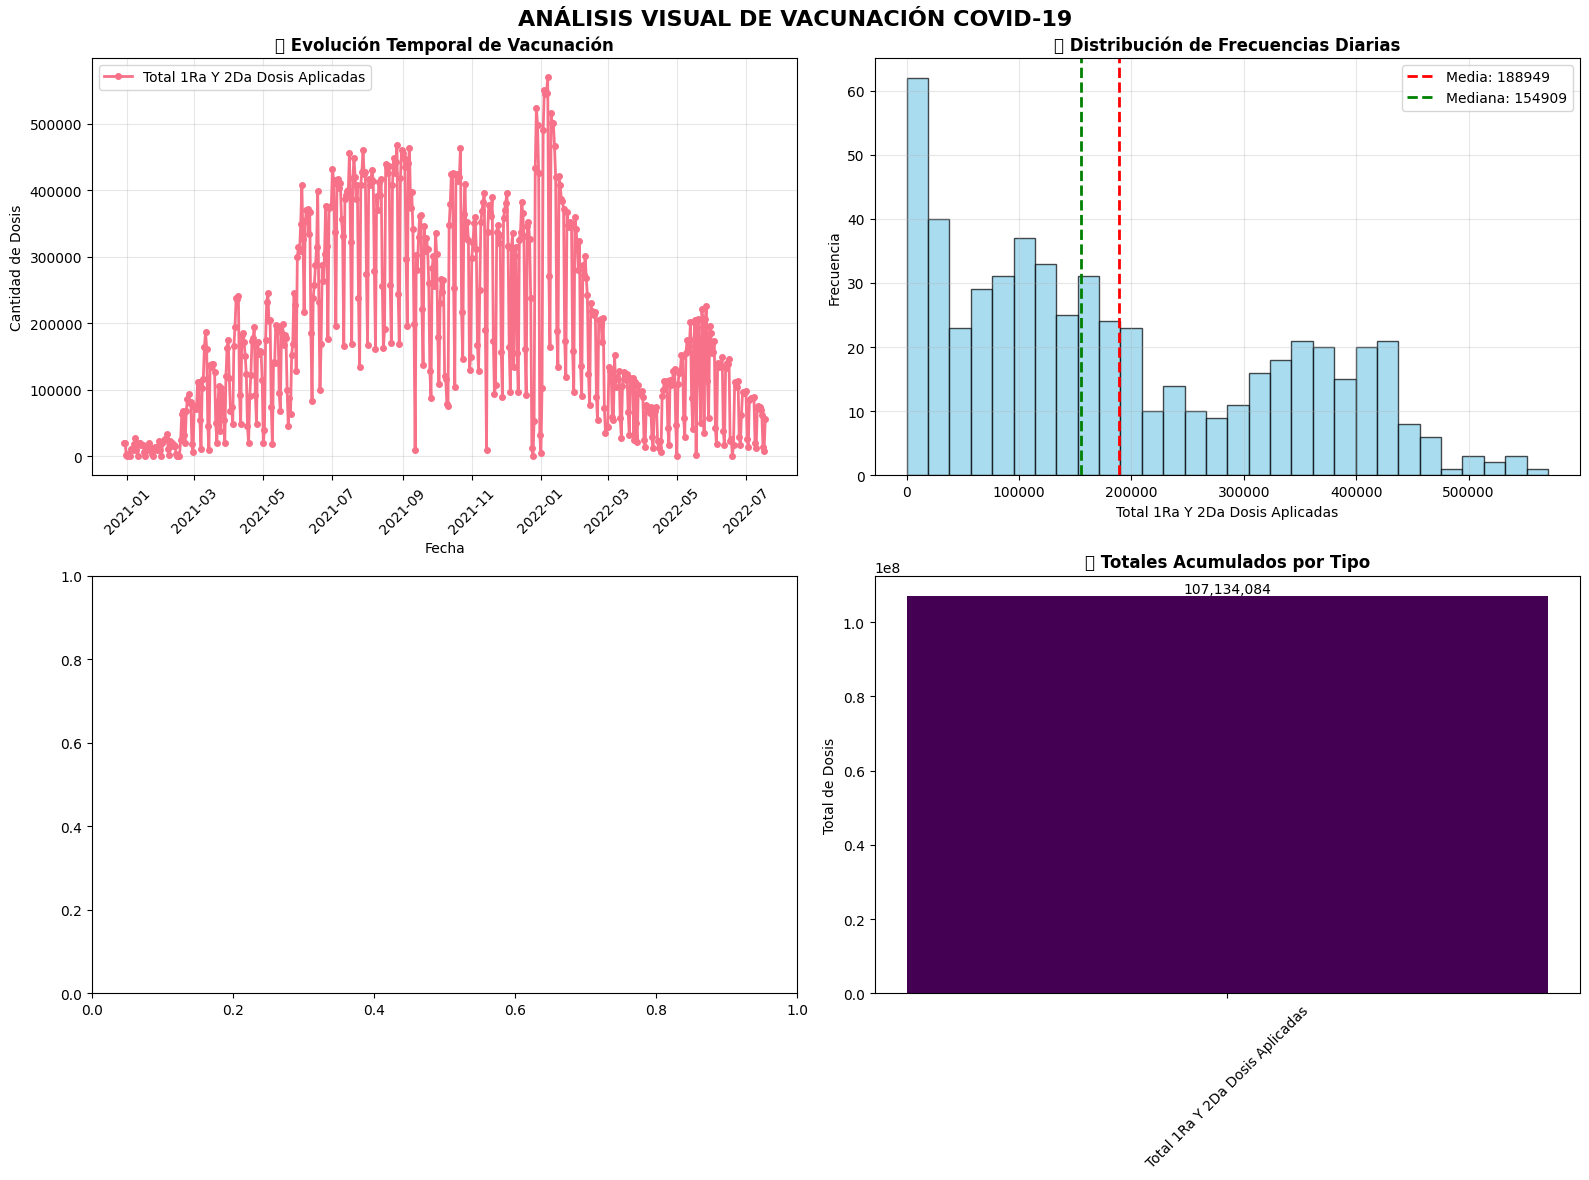


🔍 APLICANDO LEY DE BENFORD...

📊 ANÁLISIS BENFORD - TOTAL_1RA_Y_2DA_DOSIS_APLICADAS:
   🔬 Estadístico Chi²: 0.1201
   📈 P-valor: 1.0000
   ✅ Sigue Ley de Benford: SÍ


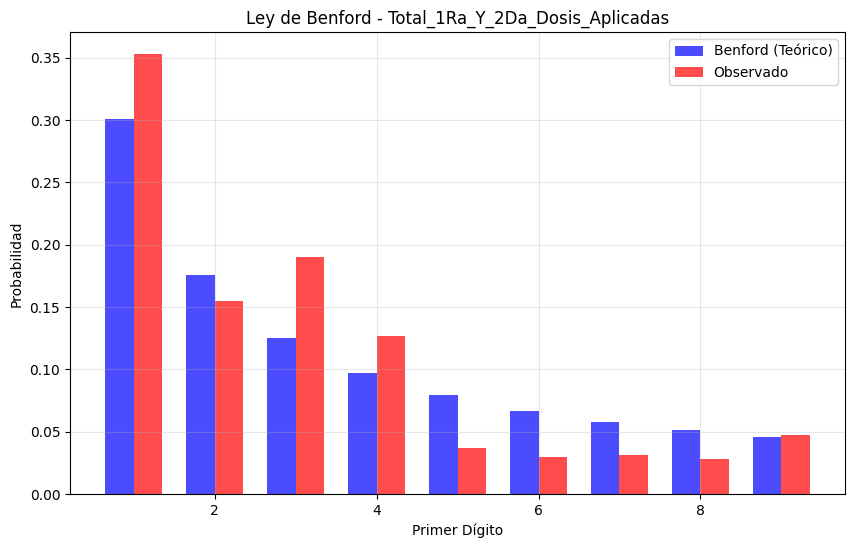


📊 ANÁLISIS DE DISTRIBUCIONES ESTADÍSTICAS...

🔸 ANÁLISIS DE DISTRIBUCIÓN - TOTAL_1RA_Y_2DA_DOSIS_APLICADAS:
   📊 Test de Normalidad:
      - Estadístico: 105.0625
      - P-valor: 0.0000
      - Es Normal: NO
   🎯 Análisis Poisson:
      - Lambda estimado: 188949.0018
      - Podría ser Poisson: NO

🎯 CALCULANDO PROBABILIDADES CONDICIONALES...

✅ ANÁLISIS COMPLETADO EXITOSAMENTE
📊 Todas las tareas han sido ejecutadas
🎯 Conclusiones disponibles en cada sección


In [2]:
# ============================================================================
# ANÁLISIS COMPLETO DE DATOS DE VACUNACIÓN COVID-19
# Ciencia de Datos para Obtener Conclusiones Significativas
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from scipy import stats
from scipy.stats import normaltest, poisson, binom
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("🔬 ANÁLISIS DE DATOS DE VACUNACIÓN COVID-19")
print("=" * 60)

# ============================================================================
# 1. CARGA Y EXPLORACIÓN INICIAL DE DATOS
# ============================================================================

def cargar_y_explorar_datos(archivo_path):
    """
    Carga el dataset y realiza exploración inicial
    """
    print("\n📂 CARGANDO Y EXPLORANDO DATOS...")
    
    # Cargar datos
    df = pd.read_csv(archivo_path)
    
    print(f"✅ Dataset cargado exitosamente")
    print(f"📊 Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
    print(f"🗂️ Columnas disponibles: {list(df.columns)}")
    
    # Información básica del dataset
    print("\n📋 INFORMACIÓN GENERAL DEL DATASET:")
    print(df.info())
    
    print("\n👀 PRIMERAS 5 FILAS:")
    print(df.head())
    
    print("\n🔍 VALORES NULOS POR COLUMNA:")
    print(df.isnull().sum())
    
    return df

# ============================================================================
# 2. LIMPIEZA DE DATOS
# ============================================================================

def limpiar_datos(df):
    """
    Limpia y prepara los datos para análisis
    """
    print("\n🧹 INICIANDO LIMPIEZA DE DATOS...")
    df_clean = df.copy()
    
    # 2.1 Identificar columnas numéricas que podrían tener formato europeo
    numeric_columns = []
    date_columns = []
    
    for col in df_clean.columns:
        # Identificar columnas de fecha
        if any(word in col.lower() for word in ['fecha', 'date', 'tiempo']):
            date_columns.append(col)
        # Identificar columnas numéricas (adaptado para tu dataset específico)
        elif any(word in col.lower() for word in ['dosis', 'dose', 'total', 'cantidad', 'num', 'monodosis', 'primera', 'segunda', '1_dosis', '2_dosis']):
            numeric_columns.append(col)
    
    print(f"📅 Columnas de fecha identificadas: {date_columns}")
    print(f"🔢 Columnas numéricas identificadas: {numeric_columns}")
    
    # 2.2 Convertir formato europeo a formato estándar
    def convertir_formato_europeo(valor):
        """
        Convierte números en formato europeo (1.234,56) a formato estándar (1234.56)
        """
        if pd.isna(valor):
            return np.nan
        
        valor_str = str(valor).strip()
        
        # Si ya es un número, devolverlo
        try:
            return float(valor_str)
        except ValueError:
            pass
        
        # Convertir formato europeo
        # Patrón: números con puntos como separadores de miles y coma como decimal
        if ',' in valor_str and '.' in valor_str:
            # Formato: 1.234.567,89
            valor_str = valor_str.replace('.', '').replace(',', '.')
        elif ',' in valor_str:
            # Formato: 1234,89
            valor_str = valor_str.replace(',', '.')
        
        try:
            return float(valor_str)
        except ValueError:
            return np.nan
    
    # 2.3 Aplicar conversión a columnas numéricas
    for col in numeric_columns:
        if col in df_clean.columns:
            print(f"🔄 Procesando columna numérica: {col}")
            df_clean[col] = df_clean[col].apply(convertir_formato_europeo)
            
            # Convertir a int si todos los valores son enteros
            if df_clean[col].notna().any():
                if df_clean[col].dropna().apply(lambda x: x == int(x)).all():
                    df_clean[col] = df_clean[col].astype('Int64')  # Nullable integer
    
    # 2.4 Convertir columnas de fecha
    for col in date_columns:
        if col in df_clean.columns:
            print(f"📅 Procesando columna de fecha: {col}")
            try:
                df_clean[col] = pd.to_datetime(df_clean[col], dayfirst=True, errors='coerce')
                print(f"✅ Fecha convertida exitosamente: {col}")
            except Exception as e:
                print(f"❌ Error al convertir fecha {col}: {e}")
    
    # 2.5 Verificar y reportar cambios
    print("\n📊 RESUMEN DE LIMPIEZA:")
    print(f"🔢 Columnas numéricas procesadas: {len(numeric_columns)}")
    print(f"📅 Columnas de fecha procesadas: {len(date_columns)}")
    print(f"❌ Valores nulos después de limpieza: {df_clean.isnull().sum().sum()}")
    
    # 2.6 Crear columnas adicionales útiles
    if date_columns:
        fecha_col = date_columns[0]
        if fecha_col in df_clean.columns:
            df_clean['año'] = df_clean[fecha_col].dt.year
            df_clean['mes'] = df_clean[fecha_col].dt.month
            df_clean['dia_semana'] = df_clean[fecha_col].dt.day_name()
            print("✅ Columnas temporales adicionales creadas")
    
    return df_clean, numeric_columns, date_columns

# ============================================================================
# 3. ESTADÍSTICA DESCRIPTIVA
# ============================================================================

def estadistica_descriptiva(df, numeric_columns):
    """
    Calcula estadísticas descriptivas completas
    """
    print("\n📈 CALCULANDO ESTADÍSTICA DESCRIPTIVA...")
    
    # 3.1 Estadísticas básicas por columna
    print("\n📊 ESTADÍSTICAS BÁSICAS:")
    for col in numeric_columns:
        if col in df.columns and df[col].notna().any():
            datos = df[col].dropna()
            
            print(f"\n🔸 {col.upper()}:")
            print(f"   📏 Total: {datos.sum():,.0f}")
            print(f"   📊 Media: {datos.mean():,.2f}")
            print(f"   📐 Mediana: {datos.median():,.2f}")
            print(f"   📏 Desv. Estándar: {datos.std():,.2f}")
            print(f"   ⬆️ Máximo: {datos.max():,.0f}")
            print(f"   ⬇️ Mínimo: {datos.min():,.0f}")
            print(f"   📈 Rango: {datos.max() - datos.min():,.0f}")
            print(f"   🎯 Coef. Variación: {(datos.std()/datos.mean())*100:.2f}%")
    
    # 3.2 Tabla resumen
    df_stats = df[numeric_columns].describe()
    print("\n📋 TABLA RESUMEN ESTADÍSTICO:")
    print(df_stats.round(2))
    
    # 3.3 Matriz de correlación
    if len(numeric_columns) > 1:
        print("\n🔗 MATRIZ DE CORRELACIÓN:")
        corr_matrix = df[numeric_columns].corr()
        print(corr_matrix.round(3))
    
    return df_stats

# ============================================================================
# 4. VISUALIZACIÓN DE DATOS
# ============================================================================

def crear_visualizaciones(df, numeric_columns, date_columns):
    """
    Crea visualizaciones comprehensivas
    """
    print("\n📊 CREANDO VISUALIZACIONES...")
    
    # Configurar subplots
    n_numeric = len(numeric_columns)
    n_plots = min(4, n_numeric + 2)  # Máximo 4 gráficos
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('ANÁLISIS VISUAL DE VACUNACIÓN COVID-19', fontsize=16, fontweight='bold')
    
    # 4.1 Gráfico de líneas: Evolución temporal
    ax1 = axes[0, 0]
    if date_columns and numeric_columns:
        fecha_col = date_columns[0]
        for i, col in enumerate(numeric_columns[:3]):  # Máximo 3 series
            if col in df.columns:
                ax1.plot(df[fecha_col], df[col], marker='o', linewidth=2, 
                        markersize=4, label=col.replace('_', ' ').title())
        
        ax1.set_title('📈 Evolución Temporal de Vacunación', fontweight='bold')
        ax1.set_xlabel('Fecha')
        ax1.set_ylabel('Cantidad de Dosis')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
    
    # 4.2 Histograma: Distribución de frecuencias
    ax2 = axes[0, 1]
    if numeric_columns:
        col_principal = numeric_columns[0]
        datos = df[col_principal].dropna()
        
        ax2.hist(datos, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax2.axvline(datos.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Media: {datos.mean():.0f}')
        ax2.axvline(datos.median(), color='green', linestyle='--', linewidth=2, 
                   label=f'Mediana: {datos.median():.0f}')
        
        ax2.set_title('📊 Distribución de Frecuencias Diarias', fontweight='bold')
        ax2.set_xlabel(col_principal.replace('_', ' ').title())
        ax2.set_ylabel('Frecuencia')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 4.3 Boxplot: Comparación de distribuciones
    ax3 = axes[1, 0]
    if len(numeric_columns) >= 2:
        datos_box = [df[col].dropna() for col in numeric_columns[:4]]
        labels_box = [col.replace('_', ' ').title() for col in numeric_columns[:4]]
        
        ax3.boxplot(datos_box, labels=labels_box)
        ax3.set_title('📦 Comparación de Distribuciones', fontweight='bold')
        ax3.set_ylabel('Valores')
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3)
    
    # 4.4 Gráfico de barras: Totales acumulados
    ax4 = axes[1, 1]
    if numeric_columns:
        totales = [df[col].sum() for col in numeric_columns[:5]]
        nombres = [col.replace('_', ' ').title() for col in numeric_columns[:5]]
        
        bars = ax4.bar(nombres, totales, color=plt.cm.viridis(np.linspace(0, 1, len(totales))))
        ax4.set_title('📊 Totales Acumulados por Tipo', fontweight='bold')
        ax4.set_ylabel('Total de Dosis')
        ax4.tick_params(axis='x', rotation=45)
        
        # Añadir valores en las barras
        for bar, total in zip(bars, totales):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{total:,.0f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# 5. LEY DE BENFORD
# ============================================================================

def aplicar_ley_benford(df, numeric_columns):
    """
    Aplica la Ley de Benford para detectar anomalías
    """
    print("\n🔍 APLICANDO LEY DE BENFORD...")
    
    # Probabilidades teóricas de Benford
    benford_probs = [np.log10(1 + 1/d) for d in range(1, 10)]
    
    for col in numeric_columns[:2]:  # Analizar las primeras 2 columnas
        if col in df.columns:
            datos = df[col].dropna()
            datos = datos[datos > 0]  # Solo valores positivos
            
            if len(datos) > 0:
                # Extraer primer dígito
                primeros_digitos = []
                for valor in datos:
                    primer_digito = int(str(int(valor))[0])
                    if primer_digito != 0:
                        primeros_digitos.append(primer_digito)
                
                if primeros_digitos:
                    # Calcular frecuencias observadas
                    digitos_unicos, conteos = np.unique(primeros_digitos, return_counts=True)
                    freq_observadas = conteos / len(primeros_digitos)
                    
                    # Crear array completo (dígitos 1-9)
                    freq_completas = np.zeros(9)
                    for i, digito in enumerate(digitos_unicos):
                        if 1 <= digito <= 9:
                            freq_completas[digito-1] = freq_observadas[i]
                    
                    # Test Chi-cuadrado
                    chi2_stat, p_value = stats.chisquare(freq_completas, benford_probs)
                    
                    print(f"\n📊 ANÁLISIS BENFORD - {col.upper()}:")
                    print(f"   🔬 Estadístico Chi²: {chi2_stat:.4f}")
                    print(f"   📈 P-valor: {p_value:.4f}")
                    print(f"   ✅ Sigue Ley de Benford: {'SÍ' if p_value > 0.05 else 'NO'}")
                    
                    # Visualización
                    plt.figure(figsize=(10, 6))
                    x = np.arange(1, 10)
                    width = 0.35
                    
                    plt.bar(x - width/2, benford_probs, width, label='Benford (Teórico)', 
                           alpha=0.7, color='blue')
                    plt.bar(x + width/2, freq_completas, width, label='Observado', 
                           alpha=0.7, color='red')
                    
                    plt.xlabel('Primer Dígito')
                    plt.ylabel('Probabilidad')
                    plt.title(f'Ley de Benford - {col.title()}')
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                    plt.show()

# ============================================================================
# 6. ANÁLISIS DE DISTRIBUCIONES
# ============================================================================

def analizar_distribuciones(df, numeric_columns):
    """
    Verifica si los datos siguen distribuciones conocidas
    """
    print("\n📊 ANÁLISIS DE DISTRIBUCIONES ESTADÍSTICAS...")
    
    for col in numeric_columns[:2]:
        if col in df.columns:
            datos = df[col].dropna()
            datos = datos[datos >= 0]  # Eliminar valores negativos
            
            if len(datos) > 8:  # Mínimo para tests estadísticos
                print(f"\n🔸 ANÁLISIS DE DISTRIBUCIÓN - {col.upper()}:")
                
                # 6.1 Test de Normalidad
                stat_norm, p_norm = normaltest(datos)
                print(f"   📊 Test de Normalidad:")
                print(f"      - Estadístico: {stat_norm:.4f}")
                print(f"      - P-valor: {p_norm:.4f}")
                print(f"      - Es Normal: {'SÍ' if p_norm > 0.05 else 'NO'}")
                
                # 6.2 Test de Poisson
                lambda_est = datos.mean()
                if lambda_est > 0:
                    # Generar distribución Poisson teórica
                    poisson_teorica = [poisson.pmf(k, lambda_est) for k in range(int(datos.max())+1)]
                    
                    # Test de bondad de ajuste
                    hist, bins = np.histogram(datos, bins=min(20, int(datos.max())+1))
                    hist_norm = hist / hist.sum()
                    
                    print(f"   🎯 Análisis Poisson:")
                    print(f"      - Lambda estimado: {lambda_est:.4f}")
                    print(f"      - Podría ser Poisson: {'SÍ' if datos.var() / datos.mean() < 2 else 'NO'}")
                
                # 6.3 Análisis Binomial (si los datos parecen conteos)
                if datos.max() <= 1000 and datos.min() >= 0:
                    n_est = int(datos.max())
                    p_est = datos.mean() / n_est if n_est > 0 else 0
                    
                    print(f"   🎲 Análisis Binomial:")
                    print(f"      - n estimado: {n_est}")
                    print(f"      - p estimado: {p_est:.4f}")
                    print(f"      - Podría ser Binomial: {'SÍ' if 0 < p_est < 1 else 'NO'}")

# ============================================================================
# 7. PROBABILIDADES CONDICIONALES
# ============================================================================

def calcular_probabilidades_condicionales(df, numeric_columns):
    """
    Calcula probabilidades condicionales y totales
    Especialmente útil para P(2da_dosis | 1era_dosis) y P(monodosis | contexto)
    """
    print("\n🎯 CALCULANDO PROBABILIDADES CONDICIONALES...")
    
    if len(numeric_columns) >= 2:
        # Buscar específicamente columnas de 1era y 2da dosis
        primera_dosis_col = None
        segunda_dosis_col = None
        monodosis_col = None
        
        for col in numeric_columns:
            col_lower = col.lower()
            if any(term in col_lower for term in ['primera', '1_dosis', 'first']):
                primera_dosis_col = col
            elif any(term in col_lower for term in ['segunda', '2_dosis', 'second']):
                segunda_dosis_col = col
            elif any(term in col_lower for term in ['monodosis', 'mono']):
                monodosis_col = col
        
        # Análisis específico para vacunación COVID
        if primera_dosis_col and segunda_dosis_col:
            df_prob = df[[primera_dosis_col, segunda_dosis_col]].dropna()
            
            if len(df_prob) > 0:
                print(f"\n🔸 ANÁLISIS: {primera_dosis_col} vs {segunda_dosis_col}")
                
                # Categorizar en Alto/Bajo basado en percentil 75
                p75_1 = df_prob[primera_dosis_col].quantile(0.75)
                p75_2 = df_prob[segunda_dosis_col].quantile(0.75)
                
                df_prob['cat1'] = df_prob[primera_dosis_col].apply(lambda x: 'Alto' if x > p75_1 else 'Bajo')
                df_prob['cat2'] = df_prob[segunda_dosis_col].apply(lambda x: 'Alto' if x > p75_2 else 'Bajo')
                
                # Tabla de contingencia
                tabla_contingencia = pd.crosstab(df_prob['cat1'], df_prob['cat2'])
                print(f"\n📊 TABLA DE CONTINGENCIA:")
                print(tabla_contingencia)
                
                # Calcular probabilidades
                total = tabla_contingencia.sum().sum()
                
                # Probabilidades condicionales clave
                if tabla_contingencia.loc['Alto'].sum() > 0:
                    p_segunda_dado_primera = tabla_contingencia.loc['Alto', 'Alto'] / tabla_contingencia.loc['Alto'].sum()
                    print(f"\n🎯 PROBABILIDAD CLAVE:")
                    print(f"   📊 P(2da Dosis Alta | 1era Dosis Alta) = {p_segunda_dado_primera:.4f}")
                    print(f"   💡 Interpretación: Si hay alta aplicación de 1era dosis,")
                    print(f"      hay {p_segunda_dado_primera*100:.1f}% probabilidad de alta aplicación de 2da dosis")
                
                # Análisis de seguimiento (completion rate)
                dias_con_ambas = len(df_prob[(df_prob[primera_dosis_col] > 0) & (df_prob[segunda_dosis_col] > 0)])
                dias_solo_primera = len(df_prob[(df_prob[primera_dosis_col] > 0) & (df_prob[segunda_dosis_col] == 0)])
                
                if dias_con_ambas + dias_solo_primera > 0:
                    tasa_seguimiento = dias_con_ambas / (dias_con_ambas + dias_solo_primera)
                    print(f"\n📈 ANÁLISIS DE SEGUIMIENTO:")
                    print(f"   - Días con ambas dosis: {dias_con_ambas}")
                    print(f"   - Días solo 1era dosis: {dias_solo_primera}")
                    print(f"   - Tasa de seguimiento: {tasa_seguimiento:.4f} ({tasa_seguimiento*100:.1f}%)")
        
        # Si no encuentra columnas específicas, usar análisis general
        else:
            col1, col2 = numeric_columns[0], numeric_columns[1]
            df_prob = df[[col1, col2]].dropna()
            
            if len(df_prob) > 0:
                # Categorizar en Alto/Bajo basado en mediana
                mediana1 = df_prob[col1].median()
                mediana2 = df_prob[col2].median()
                
                df_prob['cat1'] = df_prob[col1].apply(lambda x: 'Alto' if x > mediana1 else 'Bajo')
                df_prob['cat2'] = df_prob[col2].apply(lambda x: 'Alto' if x > mediana2 else 'Bajo')
                
                # Resto del análisis general...
                tabla_contingencia = pd.crosstab(df_prob['cat1'], df_prob['cat2'])
                print(f"\n📊 TABLA DE CONTINGENCIA ({col1} vs {col2}):")
                print(tabla_contingencia)
                
                total = tabla_contingencia.sum().sum()
                p_col1_alto = tabla_contingencia.loc['Alto'].sum() / total
                p_col2_alto = tabla_contingencia['Alto'].sum() / total
                p_col2_dado_col1_alto = tabla_contingencia.loc['Alto', 'Alto'] / tabla_contingencia.loc['Alto'].sum()
                
                print(f"\n🎯 ANÁLISIS DE PROBABILIDADES:")
                print(f"   📊 P({col1} = Alto) = {p_col1_alto:.4f}")
                print(f"   📊 P({col2} = Alto) = {p_col2_alto:.4f}")
                print(f"   🎯 P({col2} = Alto | {col1} = Alto) = {p_col2_dado_col1_alto:.4f}")
        
        # Test de independencia para cualquier caso
        if len(numeric_columns) >= 2:
            col1, col2 = numeric_columns[0], numeric_columns[1]
            df_test = df[[col1, col2]].dropna()
            if len(df_test) > 0:
                # Crear categorías para test
                df_test['cat1'] = pd.cut(df_test[col1], bins=2, labels=['Bajo', 'Alto'])
                df_test['cat2'] = pd.cut(df_test[col2], bins=2, labels=['Bajo', 'Alto'])
                
                tabla_test = pd.crosstab(df_test['cat1'], df_test['cat2'])
                chi2, p_val, dof, expected = stats.chi2_contingency(tabla_test)
                
                print(f"\n🔬 TEST DE INDEPENDENCIA:")
                print(f"   - Chi² = {chi2:.4f}")
                print(f"   - P-valor = {p_val:.4f}")
                print(f"   - Son independientes: {'SÍ' if p_val > 0.05 else 'NO'}")
                print(f"   💡 Las variables {'NO están' if p_val <= 0.05 else 'están'} relacionadas")

# ============================================================================
# 8. FUNCIÓN PRINCIPAL
# ============================================================================

def main():
    """
    Función principal que ejecuta todo el análisis
    """
    # Ruta del archivo - ELIGE UNA DE ESTAS OPCIONES:
    
    # OPCIÓN 1: Raw string (recomendada)
    archivo_path = r"C:\Users\Admin\Desktop\UNRN\3ero\Mate4\DataSet\total_de_dosis_aplicadas_a_nivel_nacional_en_valores_diarios_monodosis_1_y_2_dosis.csv"
    
    # OPCIÓN 2: Doble barra invertida
    # archivo_path = "C:\\Users\\Admin\\Desktop\\UNRN\\3ero\\Mate4\\DataSet\\total_de_dosis_aplicadas_a_nivel_nacional_en_valores_diarios_monodosis_1_y_2_dosis.csv"
    
    # OPCIÓN 3: Barra normal (funciona en Windows también)
    # archivo_path = "C:/Users/Admin/Desktop/UNRN/3ero/Mate4/DataSet/total_de_dosis_aplicadas_a_nivel_nacional_en_valores_diarios_monodosis_1_y_2_dosis.csv"
    
    try:
        # 1. Cargar y explorar datos
        df_original = cargar_y_explorar_datos(archivo_path)
        
        # 2. Limpiar datos
        df_clean, numeric_columns, date_columns = limpiar_datos(df_original)
        
        # 3. Estadística descriptiva
        stats_summary = estadistica_descriptiva(df_clean, numeric_columns)
        
        # 4. Visualizaciones
        crear_visualizaciones(df_clean, numeric_columns, date_columns)
        
        # 5. Ley de Benford
        aplicar_ley_benford(df_clean, numeric_columns)
        
        # 6. Análisis de distribuciones
        analizar_distribuciones(df_clean, numeric_columns)
        
        # 7. Probabilidades condicionales
        calcular_probabilidades_condicionales(df_clean, numeric_columns)
        
        print("\n" + "="*60)
        print("✅ ANÁLISIS COMPLETADO EXITOSAMENTE")
        print("📊 Todas las tareas han sido ejecutadas")
        print("🎯 Conclusiones disponibles en cada sección")
        print("="*60)
        
        return df_clean
        
    except Exception as e:
        print(f"❌ Error durante el análisis: {e}")
        return None

# ============================================================================
# EJECUTAR ANÁLISIS
# ============================================================================

if __name__ == "__main__":
    df_resultado = main()